mục tiêu: dự đoán nhiệt độ, lượng mưa và độ ẩm cho d ngày dựa trên 1 khoảng thời gian trước đó

=> bài toán many to many

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import pandas as pd
import math
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from livelossplot.outputs.matplotlib_plot import MatplotlibPlot
from torch.optim.lr_scheduler import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Time Series Transformer


![image.png](attachment:image.png)

Encoder-only

### 1.1. Multi-head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert dim_model % num_heads == 0, "dim_model must be divisible by num_heads"
        # khởi tạo các dimension
        self.dim_model = dim_model
        self.num_heads = num_heads
        self.dim_head = dim_model // num_heads # dim của mỗi đầu  K,Q,V

        # khởi tạo các ma trận trọng số
        self.W_q = nn.Linear(dim_model, dim_model)
        self.W_k = nn.Linear(dim_model, dim_model)
        self.W_v = nn.Linear(dim_model, dim_model)
        self.W_o = nn.Linear(dim_model, dim_model)

        self.dropout = nn.Dropout(0.1)
        # chuẩn hóa dk giúp ổn định gradient
        self.scale = torch.sqrt(torch.tensor(self.dim_head)).to(device)

    def scaled_dot_product_attention(self, Q, K, V):
        # tính attention
        attention_score = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        # tính softmax
        attention = F.softmax(attention_score, dim=-1)
        # dropout
        attention = self.dropout(attention)
        # tính attention
        output = torch.matmul(attention, V)
        return output


    # tách  vector đầu vào thành nhiều head nhỏ
    def split_heads(self, x):
        # torch.Size([16, 96, 27, 64])
        # print(x.shape)
        batch_size, seq_len, dim_model = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.dim_head)
        return x.transpose(1, 2)

    # gộp nhiều head lại thành vector đầu ra
    def combine_heads(self, x):
        batch_size, num_heads, seq_len, dim_head = x.size()
        x = x.transpose(1, 2).contiguous()
        return x.view(batch_size, seq_len, self.dim_model)


    def forward(self, Q, K, V):
        # tính Q,K,V
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
        # tách Q,K,V thành nhiều head
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        # tính attention
        attention = self.scaled_dot_product_attention(Q, K, V)
        # gộp nhiều head lại thành vector đầu ra
        attention = self.combine_heads(attention)
        # tính output
        output = self.W_o(attention)
        return output
    # batch x seq_len x dim_model

### 1.2. Feed forward networks

In [5]:
class FeedForwardNN(nn.Module):
    def __init__(self, dim_model, hidden_size = 128):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(dim_model, hidden_size)
        self.fc2 = nn.Linear(hidden_size, dim_model)
        # self.fc3 = nn.Linear(dim_ff, dim_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        # batch x seq_len x dim_model
        hidden = self.fc1(x)
        activated = self.relu(hidden)
        output = self.fc2(activated)

        return output

### 1.3. Time2Vec - thay cho Positional Encoding

giúp mô hình phân biệt từng thời điểm trong chuỗi thời gian

![image.png](attachment:image.png)

In [6]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, dim_model, max_len):
#         super().__init__()
#         # khởi tạo ma trận pe
#         pe = torch.zeros(max_len, dim_model)
#         # tensor chứa chỉ số vị trí của từng thời điẻm
#         position = torch.arange(0, max_len).unsqueeze(1).float()
#         div_term = torch.exp(torch.arange(0, dim_model, 2).float() * -(math.log(10000.0) / dim_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         # đăng ký ma trận pe như 1 bộ đệm, pe sẽ là 1 phần trạng thái nhưng không được coi là tham số có thể đào tạo được
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         pe = self.pe[:, :x.size(1)].to(device)
#         # print(x.size(), pe.size())
#         return x + pe

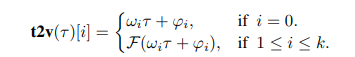

In [7]:
class Time2Vec(nn.Module):
    def __init__(self, dim_model, input_window):
        super(Time2Vec, self).__init__()
        self.input_window = input_window
        self.dim_model = dim_model
        
        # Hệ số điều chỉnh tuyến tính
        self.linear = nn.Linear(dim_model, 1)
        
        # Hệ số điều chỉnh phi tuyến với hàm sin
        self.freq = nn.Linear(dim_model, dim_model)
        self.phase = nn.Linear(dim_model, dim_model)
        
    def forward(self, t):
        # print(t.shape, self.freq(t).shape, self.phase(t).shape)
        linear_out = self.linear(t)
        periodic_out = torch.sin(self.freq(t) + self.phase(t))
        return linear_out + periodic_out

### 1.4. Encoder

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, dim_model, num_heads, hidden_size, dropout = 0.1):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(dim_model, num_heads)
        self.feed_forward_nn = FeedForwardNN(dim_model, hidden_size)
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # tính attention
        attention = self.multi_head_attention(x, x, x)
        # batch x seq_len x dim_model
        # dropout
        attention = self.dropout(attention)
        # norm
        x = self.norm1(x + attention)
        # batch x seq_len x dim_model (64)
        # feed forward
        feed_forward = self.feed_forward_nn(x)
        # batch x seq_len x dim_ff (128)
        # dropout
        feed_forward = self.dropout(feed_forward)
        # norm
        x = self.norm2(x + feed_forward)
        # dim 2: x=64, ff = 128 - đoạn này fix rồi
        return x

### 1.5. Decoder

In [9]:
# class DecoderLayer(nn.Module):
#     def __init__(self, dim_model, num_heads, hidden_size, dropout = 0.1):
#         super(DecoderLayer, self).__init__()
#         self.masked_multi_head_attention = MultiHeadAttention(dim_model, num_heads)
#         self.multi_head_attention = MultiHeadAttention(dim_model, num_heads)
#         self.feed_forward_nn = FeedForwardNN(dim_model, hidden_size)
#         self.norm1 = nn.LayerNorm(dim_model)
#         self.norm2 = nn.LayerNorm(dim_model)
#         self.norm3 = nn.LayerNorm(dim_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, encoder_output):
#         # masked multi head attention
#         masked_attention = self.masked_multi_head_attention(x, x, x)
#         # dropout
#         masked_attention = self.dropout(masked_attention)
#         # norm
#         x = self.norm1(x + masked_attention)
#         # multi head attention
#         attention = self.multi_head_attention(x, encoder_output, encoder_output)
#         # dropout
#         attention = self.dropout(attention)
#         # norm
#         x = self.norm2(x + attention)
#         # feed forward
#         feed_forward = self.feed_forward_nn(x)
#         # dropout
#         feed_forward = self.dropout(feed_forward)
#         # norm
#         x = self.norm3(x + feed_forward)
#         return x

### 1.6. TST

In [10]:

class TST(nn.Module):
    def __init__(self, input_size, dim_model, num_heads, num_layers, output_size, input_window, output_window, hidden_size, dropout=0.1):
        super(TST, self).__init__()

        self.input_window = input_window
        self.output_window = output_window
        self.dim_model = dim_model

        # Embedding cho input
        self.encoder_embedding = nn.Linear(input_size, dim_model)
        
        # Time2Vec để encode thời gian
        self.time2vec = Time2Vec(dim_model, input_window)

        # Transformer Encoder
        self.encoder_layers = nn.ModuleList([EncoderLayer(dim_model, num_heads, hidden_size, dropout) for _ in range(num_layers)])

        # Linear Projection để dự đoán toàn bộ output_window trong một lần
        self.output_projection = nn.Linear(input_window, output_window)  
        self.fc = nn.Linear(dim_model, output_size)  # Đưa về số chiều đầu ra

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (batch, input_window, input_size)
        """
        # Embedding input
        x = self.encoder_embedding(x)  # (batch, input_window, dim_model)

        # Thêm thông tin thời gian từ Time2Vec
        x_t2v = torch.arange(x.shape[1], device=x.device).float().unsqueeze(0).unsqueeze(-1).repeat(x.shape[0], 1, self.dim_model)
        x = x + self.time2vec(x_t2v)

        # Transformer Encoder
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)

        # Đưa về dạng (batch, dim_model, input_window)
        x = x.permute(0, 2, 1)  

        # One-shot dự báo toàn bộ output_window
        x = self.output_projection(x)  # (batch, dim_model, output_window)

        # Đưa về dạng (batch, output_window, output_size)
        x = x.permute(0, 2, 1)  
        x = self.fc(x)

        return x  # (batch, output_window, output_size)


In [11]:
# class TST(nn.Module):
#     def __init__(self, input_size, dim_model, num_heads,  num_layers, output_size, input_window, output_window, hidden_size, dropout = 0.1):
#         super(TST, self).__init__()

#         self.output_window = nn.Linear(input_window,output_window)
#         self.dim_model = dim_model

#         self.encoder_embedding = nn.Linear(input_size, dim_model)
#         # self.decoder_embedding = nn.Linear(input_size, dim_model)

#         # self.positional_encoding = PositionalEncoding(dim_model, input_window)
#         self.time2vec = Time2Vec(dim_model, input_window)

#         self.encoder_layers = nn.ModuleList([EncoderLayer(dim_model, num_heads, hidden_size, dropout) for _ in range(num_layers)])
#         # self.decoder_layers = nn.ModuleList([DecoderLayer(dim_model, num_heads, hidden_size, dropout) for _ in range(num_layers)])


#         self.fc = nn.Linear(dim_model, output_size) # batch x _ x output_size
#         self.dropout = nn.Dropout(dropout)
#         self.to_intput_size = nn.Linear(dim_model, input_size)


#     def forward(self, x, y=None, predict_len=0):
#         x = self.encoder_embedding(x)  # batch x input_window x dim_model
#         # x = self.positional_encoding(x)


#         x_t2v = torch.arange(x.shape[1], device=x.device).float().unsqueeze(0).unsqueeze(-1).repeat(x.shape[0], 1, self.dim_model)
#         # print(x_t2v.shape, "x_t2v ", x.shape, "x")
#         # print(self.time2vec(x_t2v).shape, "time2vec")
#         x = x + self.time2vec(x_t2v)

#         # batch x input_window x dim_model x
#         for encoder_layer in self.encoder_layers:
#             x = encoder_layer(x)

#         x = x.permute(0, 2, 1)
#         x = self.output_window(x)
#         x = x.permute(0, 2, 1) # batch x output_window x dim_model

        












        # teacher forcing 
        # if y is not None:
        #     y = self.decoder_embedding(y)
            # y = self.positional_encoding(y)
            # y_t2v = torch.arange(y.shape[1], device=y.device).float().unsqueeze(0).unsqueeze(-1).repeat(y.shape[0], 1, self.dim_model)
            # y = y + self.time2vec(y_t2v)
            # for decoder_layer in self.decoder_layers:
                # y = decoder_layer(y, x)

            # y = self.fc(y)
            # y = self.dropout(y)
            # return y


        # pred = []
        # last_pred = x[:, -1, :] # batch x dim_model
        # last_pred = last_pred.unsqueeze(1) # batch x 1 x dim_model

        # last_pred = self.to_intput_size(last_pred) # batch x 1 x input_size


        # for _ in range(predict_len):
        #     last_pred = self.decoder_embedding(last_pred)
        #     # batch x 1 x dim_model
        #     # last_pred = self.positional_encoding(last_pred)
        #     last_pred_t2v = torch.arange(last_pred.shape[1], device=last_pred.device).float().unsqueeze(0).unsqueeze(-1).repeat(last_pred.shape[0], 1, self.dim_model)
        #     last_pred = last_pred + self.time2vec(last_pred_t2v)
        #     # batch x 1 x input_window
            
            
        #     # for decoder_layer in self.decoder_layers:
        #         # last_pred = decoder_layer(last_pred, x)
        #         # batch x 1 x dim_model


        #     last_pred = self.fc(last_pred) # batch x 1 x output_size
        #     last_pred = self.dropout(last_pred)
        #     pred.append(last_pred)

        # return torch.cat(pred, dim=1)


## 2. Mô hình

### 2.1. chuyển dataframe thành tensor để tính toán

In [12]:
df = pd.read_csv('hanoi_weather_2001_2024_cleaned.csv')
df.head()

,T2M,ALLSKY_SFC_SW_DWN,RH2M,WS2M,T2MDEW,T2MWET,PS,WS50M,ALLSKY_SFC_LW_DWN,WD50M,...,WS10M,GWETPROF,TS,WD10M,ALLSKY_SFC_PAR_TOT,QV2M,ALLSKY_KT,CLRSKY_SFC_SW_DWN,GWETROOT,GWETTOP
0,13.230000,0.0,80.270,0.900000,9.940000,11.580000,100.640000,2.560000,307.380000,186.300000,...,1.690000,0.65,10.760000,186.500000,0.0,7.580000,0.22,0.0,0.59,0.63
1,12.985000,0.0,81.235,0.880000,9.875000,11.425000,100.615000,2.505000,305.000000,186.300000,...,1.655000,0.65,10.560000,186.250000,0.0,7.550000,0.22,0.0,0.59,0.63
2,12.793333,0.0,81.960,0.846667,9.813333,11.300000,100.596667,2.376667,304.633333,187.533333,...,1.576667,0.65,10.366667,187.400000,0.0,7.523333,0.22,0.0,0.59,0.63
3,12.446667,0.0,83.150,0.756667,9.686667,11.066667,100.570000,2.046667,303.190000,192.166667,...,1.370000,0.65,9.986667,192.166667,0.0,7.463333,0.22,0.0,0.59,0.63
4,12.186667,0.0,83.860,0.633333,9.556667,10.873333,100.566667,1.596667,302.956667,202.833333,...,1.086667,0.65,9.633333,203.233333,0.0,7.400000,0.22,0.0,0.59,0.63


In [13]:
df.columns

Index(['T2M', 'ALLSKY_SFC_SW_DWN', 'RH2M', 'WS2M', 'T2MDEW', 'T2MWET', 'PS',
       'WS50M', 'ALLSKY_SFC_LW_DWN', 'WD50M', 'WD2M', 'ALLSKY_SFC_SW_DIFF',
       'ALLSKY_SFC_SW_DNI', 'ALLSKY_SRF_ALB', 'CLOUD_AMT', 'PRECTOTCORR',
       'TOA_SW_DWN', 'WS10M', 'GWETPROF', 'TS', 'WD10M', 'ALLSKY_SFC_PAR_TOT',
       'QV2M', 'ALLSKY_KT', 'CLRSKY_SFC_SW_DWN', 'GWETROOT', 'GWETTOP'],
      dtype='object')

1. Nhiệt độ & Độ ẩm
- T2M: Nhiệt độ không khí ở độ cao 2m
- T2MDEW: Nhiệt độ điểm sương ở độ cao 2m
- T2MWET: Nhiệt độ bầu ướt ở độ cao 2m
- TS: Nhiệt độ bề mặt đất
- QV2M: Tỷ lệ trộn hơi nước ở độ cao 2m
- RH2M: Độ ẩm tương đối ở độ cao 2m
2. Áp suất khí quyển
- PS: Áp suất khí quyển bề mặt
3. Gió
- WS2M: Tốc độ gió ở độ cao 2m
- WS10M: Tốc độ gió ở độ cao 10m
- WS50M: Tốc độ gió ở độ cao 50m
- WD2M: Hướng gió ở độ cao 2m
- WD10M: Hướng gió ở độ cao 10m
- WD50M: Hướng gió ở độ cao 50m
4. Bức xạ mặt trời & Năng lượng
- ALLSKY_SFC_SW_DWN: Tổng bức xạ mặt trời xuống bề mặt
- ALLSKY_SFC_SW_DIFF: Thành phần khuếch tán của bức xạ mặt trời
- ALLSKY_SFC_SW_DNI: Bức xạ mặt trời trực tiếp xuống bề mặt
- ALLSKY_SFC_LW_DWN: Bức xạ sóng dài từ bầu trời xuống bề mặt
- ALLSKY_SRF_ALB: Suất phản chiếu (albedo) của bề mặt
- TOA_SW_DWN: Bức xạ sóng ngắn chiếu xuống đỉnh khí quyển
- ALLSKY_SFC_PAR_TOT: Tổng bức xạ hoạt động quang hợp
- ALLSKY_KT: Chỉ số trong suốt của bầu trời
- CLRSKY_SFC_SW_DWN: Bức xạ mặt trời trong điều kiện trời quang
5. Lượng mưa & Mây
- PRECTOTCORR: Lượng mưa tổng cộng
- CLOUD_AMT: Lượng mây trung bình
6. Độ ẩm đất
- GWETPROF: Độ ẩm đất trong toàn bộ hồ sơ đất
- GWETROOT: Độ ẩm đất trong vùng rễ cây
- GWETTOP: Độ ẩm đất ở lớp trên cùng

In [14]:
df1 = df.copy()

scaler = StandardScaler()
df1 = scaler.fit_transform(df1)
df1 = pd.DataFrame(df1, columns=df.columns)
df1.head()

,T2M,ALLSKY_SFC_SW_DWN,RH2M,WS2M,T2MDEW,T2MWET,PS,WS50M,ALLSKY_SFC_LW_DWN,WD50M,...,WS10M,GWETPROF,TS,WD10M,ALLSKY_SFC_PAR_TOT,QV2M,ALLSKY_KT,CLRSKY_SFC_SW_DWN,GWETROOT,GWETTOP
0,-1.634956,-0.697507,-0.145915,-0.834983,-1.661661,-1.708928,0.750187,-0.792713,-2.733737,0.627933,...,-0.724546,-0.782886,-1.894309,0.632424,-0.703138,-1.580103,-0.398694,-0.78876,-0.87909,-0.830634
1,-1.674612,-0.697507,-0.077945,-0.854908,-1.672519,-1.735339,0.715609,-0.823685,-2.795748,0.627933,...,-0.751390,-0.782886,-1.924175,0.629320,-0.703138,-1.586154,-0.398694,-0.78876,-0.87909,-0.830634
2,-1.705636,-0.697507,-0.026879,-0.888116,-1.682820,-1.756639,0.690251,-0.895954,-2.805301,0.643285,...,-0.811469,-0.782886,-1.953046,0.643596,-0.703138,-1.591533,-0.398694,-0.78876,-0.87909,-0.830634
3,-1.761748,-0.697507,0.056940,-0.977777,-1.703978,-1.796397,0.653368,-1.081788,-2.842907,0.700960,...,-0.969977,-0.782886,-2.009791,0.702768,-0.703138,-1.603634,-0.398694,-0.78876,-0.87909,-0.830634
4,-1.803832,-0.697507,0.106950,-1.100646,-1.725693,-1.829340,0.648758,-1.335198,-2.848987,0.833735,...,-1.187286,-0.782886,-2.062554,0.840147,-0.703138,-1.616408,-0.398694,-0.78876,-0.87909,-0.830634


#### PCA

In [15]:
# pca
pca = PCA(n_components=0.95)
df1 = pca.fit_transform(df1)

feature_importance = np.abs(pca.components_).sum(axis=0)

f_name = df.columns
important_f = pd.DataFrame({'Feature': f_name, 'Importance': feature_importance})
important_f = important_f.sort_values(by='Importance', ascending=False)
top18 = important_f.head(20)
top18

,Feature,Importance
15,PRECTOTCORR,2.101289
13,ALLSKY_SRF_ALB,1.830833
14,CLOUD_AMT,1.686926
2,RH2M,1.474935
12,ALLSKY_SFC_SW_DNI,1.407859
7,WS50M,1.370687
9,WD50M,1.283831
10,WD2M,1.280911
20,WD10M,1.279035
18,GWETPROF,1.259588


In [16]:
top18['Feature'].values.tolist()

['PRECTOTCORR',
 'ALLSKY_SRF_ALB',
 'CLOUD_AMT',
 'RH2M',
 'ALLSKY_SFC_SW_DNI',
 'WS50M',
 'WD50M',
 'WD2M',
 'WD10M',
 'GWETPROF',
 'ALLSKY_KT',
 'WS10M',
 'WS2M',
 'GWETROOT',
 'ALLSKY_SFC_LW_DWN',
 'T2M',
 'T2MDEW',
 'ALLSKY_SFC_SW_DIFF',
 'QV2M',
 'TS']

In [17]:
dff = df.copy()
dff = dff[top18['Feature'].values.tolist()]
dff.shape

(210384, 20)

In [18]:
dff.head()

,PRECTOTCORR,ALLSKY_SRF_ALB,CLOUD_AMT,RH2M,ALLSKY_SFC_SW_DNI,WS50M,WD50M,WD2M,WD10M,GWETPROF,ALLSKY_KT,WS10M,WS2M,GWETROOT,ALLSKY_SFC_LW_DWN,T2M,T2MDEW,ALLSKY_SFC_SW_DIFF,QV2M,TS
0,0.0,0.23,1.220,80.270,0.0,2.560000,186.300000,186.400000,186.500000,0.65,0.22,1.690000,0.900000,0.59,307.380000,13.230000,9.940000,0.0,7.580000,10.760000
1,0.0,0.23,1.425,81.235,0.0,2.505000,186.300000,186.200000,186.250000,0.65,0.22,1.655000,0.880000,0.59,305.000000,12.985000,9.875000,0.0,7.550000,10.560000
2,0.0,0.23,1.630,81.960,0.0,2.376667,187.533333,187.333333,187.400000,0.65,0.22,1.576667,0.846667,0.59,304.633333,12.793333,9.813333,0.0,7.523333,10.366667
3,0.0,0.23,2.040,83.150,0.0,2.046667,192.166667,192.300000,192.166667,0.65,0.22,1.370000,0.756667,0.59,303.190000,12.446667,9.686667,0.0,7.463333,9.986667
4,0.0,0.23,2.450,83.860,0.0,1.596667,202.833333,203.933333,203.233333,0.65,0.22,1.086667,0.633333,0.59,302.956667,12.186667,9.556667,0.0,7.400000,9.633333


#### chia tập train val test

In [19]:
# chia tập train val test
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

train_df = dff[:train_size]
val_df = dff[train_size:train_size + val_size]
test_df = dff[train_size + val_size:]

In [20]:
train_df.shape

(147268, 20)

#### chuẩn hóa

In [21]:
# chuẩn hóa dữ liệu, giup cho mô hình học tốt hơn
scaler = StandardScaler()
train = scaler.fit_transform(train_df)
val = scaler.transform(val_df)
test = scaler.transform(test_df)
# bỏ cột date đi vì không cần thiết, TST có thể biết thời điểm nếu data được xếp tuần tự
train

array([[-0.35258373,  1.49517478, -2.43321398, ..., -0.7735585 ,
        -1.55527777, -1.87204537],
       [-0.35258373,  1.49517478, -2.42659119, ..., -0.7735585 ,
        -1.56137819, -1.90158192],
       [-0.35258373,  1.49517478, -2.4199684 , ..., -0.7735585 ,
        -1.56680078, -1.93013392],
       ...,
       [-0.35258373,  0.51826053,  0.23367012, ..., -0.7735585 ,
        -0.14472534, -0.54880799],
       [-0.35258373,  0.56967707,  0.45098375, ..., -0.7735585 ,
        -0.17048267, -0.58474413],
       [-0.35258373,  0.6210936 ,  0.49492031, ..., -0.7735585 ,
        -0.19285087, -0.60935792]])

#### dataloader

In [22]:
# đưa về tensor
train_tensor, val_tensor, test_tensor = map(torch.tensor, (train, val, test))
type(train_tensor)

torch.Tensor

In [23]:
batch_size = 32

In [24]:
# sliding window - chia tập thành các mẫu dữ liệu nhỏ hơn và giữ nguyên thứ tự thời gian

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        self.data = data
        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        return len(self.data) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_window]
        y = self.data[idx + self.input_window:idx + self.input_window + self.output_window]
        return x, y

input_window = 24*7
output_window = 24
train_dataset = TimeSeriesDataset(train_tensor, input_window, output_window)
val_dataset = TimeSeriesDataset(val_tensor, input_window, output_window)
test_dataset = TimeSeriesDataset(test_tensor, input_window, output_window)



In [25]:
x, y = train_dataset[0]
print(f"x shape: {x.shape}")  # Expect: (30, feature_dim)
print(f"y shape: {y.shape}")  # Expect: (7, feature_dim)


x shape: torch.Size([168, 20])
y shape: torch.Size([24, 20])


In [26]:

# dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
train_loader.dataset[0][0].shape

torch.Size([168, 20])

### 2.2. Xây dựng mô hình

In [34]:
input_size = dff.shape[1]
output_size = dff.shape[1]

num_epoch = 100
n_layers = 2
dim_model = 16
num_heads = 2
lr = 1e-3
weight_decay = 5e-4
dropout = 0.2
hidden_size = 32


model = TST(input_size, dim_model, num_heads, n_layers, output_size, input_window, output_window, hidden_size, dropout)
model.to(device)

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=0.95)

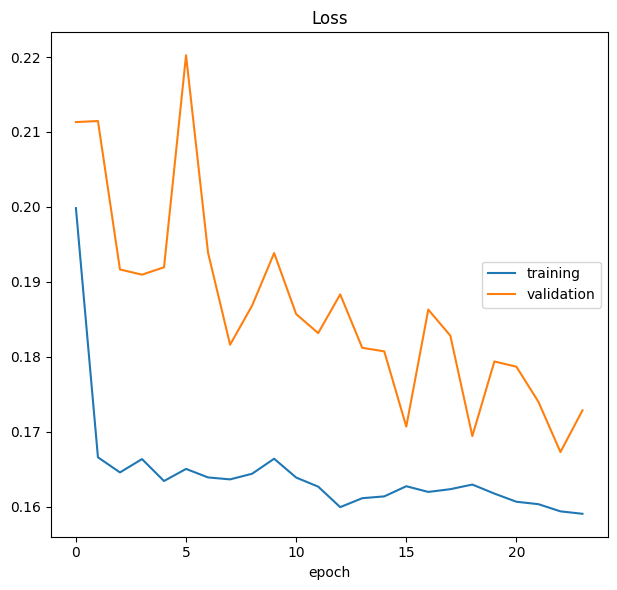

Epoch 24/100 train loss: 0.15903082 val loss: 0.17284088


KeyboardInterrupt: 

In [35]:
plt.ion()
liveplot = PlotLosses(outputs=[MatplotlibPlot(figsize=(12, 6))])

train_losses = []
val_losses = []
patience = 5
stop = 0.0
counter = 0
for epoch in range(num_epoch):
    model.train()
    train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad()
        output = model(x)
        # output = scaler.inverse_transform(output)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            x, y = x.float().to(device), y.float().to(device)
            output = model(x)

            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    # thêm early stopping
    if val_loss < stop:
        # best_val_loss = val_loss
        counter = 0  # Reset bộ đếm
        # torch.save(model.state_dict(), "best_model.pth")  # Lưu mô hình tốt nhất
    elif val_loss >= stop and counter == 0:
        stop = val_loss
        counter += 1
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break  # Dừng huấn luyện

    liveplot.update({
        'loss': train_loss,
        'val_loss': val_loss
    })
    liveplot.send()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epoch} train loss: {train_loss:.8f} val loss: {val_loss:.8f}")
plt.ioff()
plt.show()

In [ ]:
# save model 
torch.save(model.state_dict(), "model.pth")


In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name}: {param.grad.norm().item()}")


encoder_embedding.weight: 0.0751665011048317
encoder_embedding.bias: 0.013487010262906551
time2vec.linear.weight: 0.0027056869585067034
time2vec.linear.bias: 5.777935712103499e-06
time2vec.freq.weight: 0.6661435961723328
time2vec.freq.bias: 0.0010582228424027562
time2vec.phase.weight: 0.6661435961723328
time2vec.phase.bias: 0.0010582228424027562
encoder_layers.0.multi_head_attention.W_q.weight: 0.0021728777792304754
encoder_layers.0.multi_head_attention.W_q.bias: 3.157465471304022e-05
encoder_layers.0.multi_head_attention.W_k.weight: 0.0023167580366134644
encoder_layers.0.multi_head_attention.W_k.bias: 1.1890144359545662e-13
encoder_layers.0.multi_head_attention.W_v.weight: 0.017712589353322983
encoder_layers.0.multi_head_attention.W_v.bias: 0.0010937952902168036
encoder_layers.0.multi_head_attention.W_o.weight: 0.013086231425404549
encoder_layers.0.multi_head_attention.W_o.bias: 0.01360640674829483
encoder_layers.0.feed_forward_nn.fc1.weight: 0.0
encoder_layers.0.feed_forward_nn.fc1.b

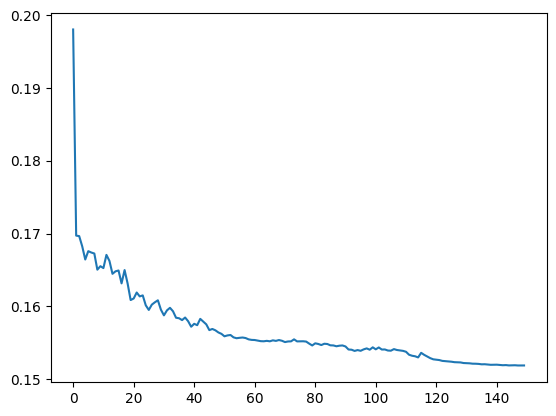

In [ ]:
# xem train_loss
plt.plot(train_losses, label='train loss')
plt.show()

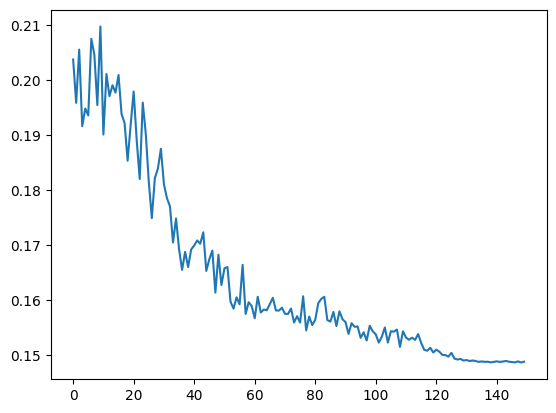

In [ ]:
plt.plot(val_losses, label='val loss')
plt.show()
# num_epoch = 50, lr = 5e-4

## 3. Dự báo thời tiết cho tương lai

In [ ]:

model.eval()

TST(
  (encoder_embedding): Linear(in_features=20, out_features=16, bias=True)
  (time2vec): Time2Vec(
    (linear): Linear(in_features=16, out_features=1, bias=True)
    (freq): Linear(in_features=16, out_features=16, bias=True)
    (phase): Linear(in_features=16, out_features=16, bias=True)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (multi_head_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward_nn): FeedForwardNN(
        (fc1): Linear(in_features=16, out_features=32, bias=True)
        (fc2): Linear(in_features=32, out_features=16, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)

In [ ]:
input_new = test_tensor[-input_window*3:-input_window*2].unsqueeze(0).float().to(device)


In [ ]:
input_new.shape

torch.Size([1, 168, 20])

In [ ]:
df.iloc[-input_window*3:-input_window*2, 0]

209880    18.300000
209881    18.156667
209882    18.030000
209883    17.906667
209884    17.760000
            ...    
210043    16.216667
210044    15.636667
210045    15.283333
210046    15.046667
210047    14.710000
Name: T2M, Length: 168, dtype: float64

In [ ]:


# dự báo thời tiết 2 ngày
with torch.no_grad():
    output = model(input_new)
    output = output.squeeze(0).cpu().numpy()
    output = scaler.inverse_transform(output)
    output = pd.DataFrame(output, columns=dff.columns)


In [ ]:
predicted_day = np.arange(0, output_window)

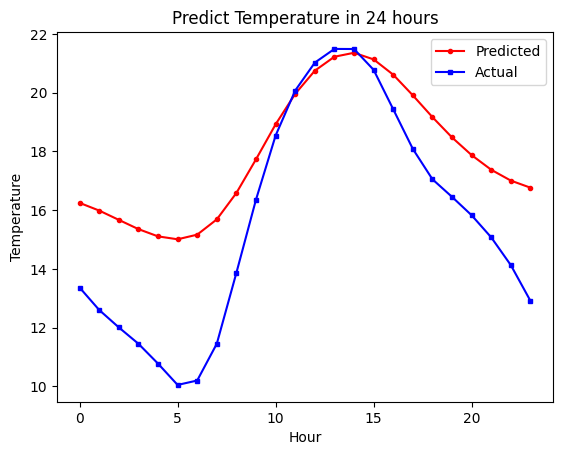

In [ ]:
plt.plot(predicted_day,output['T2M'], marker='o', markersize=3, color='r', label='Predicted')
plt.plot(predicted_day,df.iloc[-input_window*2+1:-input_window*2+output_window+1, 0], marker='s', markersize=3, color='b', label='Actual')

plt.legend()
plt.xlabel('Hour')
# plt.xticks(predicted_day)
plt.ylabel('Temperature')
plt.title('Predict Temperature in 24 hours')
plt.show()